In [91]:
from savant_data_downloader.savant_data_downloader import get_new_data
import polars as pl
from datetime import datetime
import pybaseball as pb
import pprint

In [2]:
start_date = '2025-02-01'
end_date = '2025-02-25'

# Pull all spring training pitches
data = get_new_data(start_date, end_date)

Fetching Statcast Data: 100%|███████████████████| 25/25 [00:00<00:00, 68.71it/s]


In [3]:
data.shape

(12967, 113)

In [4]:
data.head()

pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,…,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,hyper_speed,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
str,date,f64,f64,f64,str,i64,i64,str,str,i64,i64,i64,i64,i64,str,str,str,str,str,str,str,i64,str,i64,i64,i64,f64,f64,f64,f64,i64,i64,i64,i64,i64,str,…,str,i64,i64,i64,i64,i64,i64,i64,i64,str,str,i64,f64,i64,f64,f64,f64,i64,f64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,i64
"""CH""",2025-02-20,87.6,-1.79,6.03,"""Poteet, Cody""",687221,547001,"""walk""","""ball""",null,null,null,null,11,"""Dalton Rushing walks.""","""S""","""L""","""R""","""LAD""","""CHC""","""B""",null,null,3,2,2025,-1.05,0.24,-2.39,4.3,676439,null,null,1,2,"""Bot""",…,"""Changeup""",3,0,3,0,0,3,3,0,"""Strategic""","""Standard""",238,0.005,null,null,null,null,null,null,3,3,0.858,0.858,30,24,31,24,1,0,null,null,null,null,2.71,1.05,-1.05,null
"""CH""",2025-02-20,88.4,-1.67,6.05,"""Poteet, Cody""",687221,547001,null,"""ball""",null,null,null,null,11,"""Dalton Rushing walks.""","""S""","""L""","""R""","""LAD""","""CHC""","""B""",null,null,2,2,2025,-1.22,0.28,-2.76,3.53,676439,null,null,1,2,"""Bot""",…,"""Changeup""",3,0,3,0,0,3,3,0,"""Strategic""","""Standard""",235,0.0,null,null,null,null,null,null,3,3,0.858,0.858,30,24,31,24,1,0,null,null,null,null,2.64,1.22,-1.22,null
"""FF""",2025-02-20,94.8,-1.22,6.28,"""Poteet, Cody""",687221,547001,null,"""ball""",null,null,null,null,11,"""Dalton Rushing walks.""","""S""","""L""","""R""","""LAD""","""CHC""","""B""",null,null,1,2,2025,-0.66,1.35,-0.13,4.67,676439,null,null,1,2,"""Bot""",…,"""4-Seam Fastball""",3,0,3,0,0,3,3,0,"""Strategic""","""Standard""",218,0.0,null,null,null,null,null,null,3,3,0.858,0.858,30,24,31,24,1,0,null,null,null,null,1.2,0.66,-0.66,null
"""CH""",2025-02-20,90.1,-1.6,6.03,"""Poteet, Cody""",687221,547001,null,"""ball""",null,null,null,null,14,"""Dalton Rushing walks.""","""S""","""L""","""R""","""LAD""","""CHC""","""B""",null,null,0,2,2025,-1.06,0.35,1.1,0.09,623520,676439,null,1,2,"""Bot""",…,"""Changeup""",2,0,2,0,0,3,3,0,"""Strategic""","""Standard""",245,0.044,null,null,null,null,null,null,2,2,0.814,0.814,30,24,31,24,1,0,null,null,null,null,2.47,1.06,-1.06,null
"""CH""",2025-02-20,89.0,-1.75,6.0,"""Poteet, Cody""",687221,547001,null,"""swinging_strike""",null,null,null,null,7,"""Dalton Rushing walks.""","""S""","""L""","""R""","""LAD""","""CHC""","""S""",null,null,0,1,2025,-1.26,0.13,-0.52,1.55,623520,676439,null,1,2,"""Bot""",…,"""Changeup""",2,0,2,0,0,2,2,0,"""Strategic""","""Standard""",244,0.0,null,null,null,null,null,null,2,2,0.814,0.814,30,24,31,24,1,0,null,null,null,null,2.76,1.26,-1.26,null


In [5]:
data.columns

['pitch_type',
 'game_date',
 'release_speed',
 'release_pos_x',
 'release_pos_z',
 'player_name',
 'batter',
 'pitcher',
 'events',
 'description',
 'spin_dir',
 'spin_rate_deprecated',
 'break_angle_deprecated',
 'break_length_deprecated',
 'zone',
 'des',
 'game_type',
 'stand',
 'p_throws',
 'home_team',
 'away_team',
 'type',
 'hit_location',
 'bb_type',
 'balls',
 'strikes',
 'game_year',
 'pfx_x',
 'pfx_z',
 'plate_x',
 'plate_z',
 'on_3b',
 'on_2b',
 'on_1b',
 'outs_when_up',
 'inning',
 'inning_topbot',
 'hc_x',
 'hc_y',
 'tfs_deprecated',
 'tfs_zulu_deprecated',
 'umpire',
 'sv_id',
 'vx0',
 'vy0',
 'vz0',
 'ax',
 'ay',
 'az',
 'sz_top',
 'sz_bot',
 'hit_distance_sc',
 'launch_speed',
 'launch_angle',
 'effective_speed',
 'release_spin_rate',
 'release_extension',
 'game_pk',
 'fielder_2',
 'fielder_3',
 'fielder_4',
 'fielder_5',
 'fielder_6',
 'fielder_7',
 'fielder_8',
 'fielder_9',
 'release_pos_y',
 'estimated_ba_using_speedangle',
 'estimated_woba_using_speedangle',
 'w

# Which Teams have the ABS review?
ESPN Says it's these home teams: [link](https://www.espn.com/mlb/story/_/id/43911443/spring-training-games-feature-automated-ball-strike-challenge-system)


In [6]:
AZ_home_teams = ['SEA', 'SD', 'CWS', 'LAD', 'KC', 'TEX', 'CIN', 'CLE', 'COL', 'AZ']
FL_home_teams = ['TOR', 'DET', 'NYY', 'PIT', 'PHI', 'NYM', 'STL', 'MIA']
ABS_home_teams = AZ_home_teams + FL_home_teams

Filter Data to only games where relevant home teams exist

In [7]:
abs_relevant_pitches = data.filter(
    pl.col('home_team').is_in(ABS_home_teams)
)

In [8]:
abs_relevant_pitches.shape

(9055, 113)

Okay, that filtered out some pitches, but not a ton. Let's start by seeing if there's anything in these data that can help me determine if the pitch was challenged. 

In [9]:
all_outcomes = abs_relevant_pitches.select('description').to_series().unique()
for a in all_outcomes:
    print(a)

foul
missed_bunt
hit_by_pitch
foul_tip
hit_into_play
blocked_ball
ball
foul_bunt
swinging_strike_blocked
called_strike
swinging_strike


Sadly, there's no 'challenged' label here, but I can do some more filtering here. You can only challenge called strikes or balls. 

In [10]:
abs_relevant_pitches = abs_relevant_pitches.filter(
    pl.col('description').is_in(['ball', 'called_strike'])
)

In [11]:
abs_relevant_pitches.head()

pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,…,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,hyper_speed,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
str,date,f64,f64,f64,str,i64,i64,str,str,i64,i64,i64,i64,i64,str,str,str,str,str,str,str,i64,str,i64,i64,i64,f64,f64,f64,f64,i64,i64,i64,i64,i64,str,…,str,i64,i64,i64,i64,i64,i64,i64,i64,str,str,i64,f64,i64,f64,f64,f64,i64,f64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,i64
"""CH""",2025-02-20,87.6,-1.79,6.03,"""Poteet, Cody""",687221,547001,"""walk""","""ball""",null,null,null,null,11,"""Dalton Rushing walks.""","""S""","""L""","""R""","""LAD""","""CHC""","""B""",null,null,3,2,2025,-1.05,0.24,-2.39,4.3,676439,null,null,1,2,"""Bot""",…,"""Changeup""",3,0,3,0,0,3,3,0,"""Strategic""","""Standard""",238,0.005,null,null,null,null,null,null,3,3,0.858,0.858,30,24,31,24,1,0,null,null,null,null,2.71,1.05,-1.05,null
"""CH""",2025-02-20,88.4,-1.67,6.05,"""Poteet, Cody""",687221,547001,null,"""ball""",null,null,null,null,11,"""Dalton Rushing walks.""","""S""","""L""","""R""","""LAD""","""CHC""","""B""",null,null,2,2,2025,-1.22,0.28,-2.76,3.53,676439,null,null,1,2,"""Bot""",…,"""Changeup""",3,0,3,0,0,3,3,0,"""Strategic""","""Standard""",235,0.0,null,null,null,null,null,null,3,3,0.858,0.858,30,24,31,24,1,0,null,null,null,null,2.64,1.22,-1.22,null
"""FF""",2025-02-20,94.8,-1.22,6.28,"""Poteet, Cody""",687221,547001,null,"""ball""",null,null,null,null,11,"""Dalton Rushing walks.""","""S""","""L""","""R""","""LAD""","""CHC""","""B""",null,null,1,2,2025,-0.66,1.35,-0.13,4.67,676439,null,null,1,2,"""Bot""",…,"""4-Seam Fastball""",3,0,3,0,0,3,3,0,"""Strategic""","""Standard""",218,0.0,null,null,null,null,null,null,3,3,0.858,0.858,30,24,31,24,1,0,null,null,null,null,1.2,0.66,-0.66,null
"""CH""",2025-02-20,90.1,-1.6,6.03,"""Poteet, Cody""",687221,547001,null,"""ball""",null,null,null,null,14,"""Dalton Rushing walks.""","""S""","""L""","""R""","""LAD""","""CHC""","""B""",null,null,0,2,2025,-1.06,0.35,1.1,0.09,623520,676439,null,1,2,"""Bot""",…,"""Changeup""",2,0,2,0,0,3,3,0,"""Strategic""","""Standard""",245,0.044,null,null,null,null,null,null,2,2,0.814,0.814,30,24,31,24,1,0,null,null,null,null,2.47,1.06,-1.06,null
"""FF""",2025-02-20,94.2,-1.34,6.33,"""Poteet, Cody""",808975,547001,null,"""ball""",null,null,null,null,11,"""Hyeseong Kim grounds out softl…","""S""","""L""","""R""","""LAD""","""CHC""","""B""",null,null,2,2,2025,-0.64,1.26,-0.84,3.8,623520,676439,null,0,2,"""Bot""",…,"""4-Seam Fastball""",2,0,2,0,0,2,2,0,"""Strategic""","""Standard""",218,0.0,null,null,null,null,null,null,2,2,0.849,0.849,30,26,31,26,1,0,null,null,null,null,1.29,0.64,-0.64,null


Here's a pretty good universe of pitches that could be challenged. Let's start by manually grabbing a few games with challenged pitches and go from there. 

The rules say that:
- During the spring, each team will be given two challenges per game and will retain successful challenges.

The Yankees are always in the news, so let's start with them. https://www.espn.com/mlb/story/_/id/43973088/new-york-yankees-use-abs-challenge-system-keep-inning-alive 

This article says that: 
- On Feb 22, 2025
- The Yankees used an ABS challenge successfully
- Batter: Everson Pereira
- Away Team: New York Yankees
- Home Team: Toronto Blue Jays
- Top of the 6th inning, 2 outs, full count
- Pitch: Last pitch of the AB, caused him to walk

In [12]:
everson_pereira = pb.playerid_lookup('pereira', 'everson')
everson_pereira.key_mlbam[0]

Gathering player lookup table. This may take a moment.


np.int64(677592)

In [13]:
pereira_challenge = abs_relevant_pitches.filter(
    (pl.col('batter')==everson_pereira.key_mlbam[0]) &
    (pl.col('game_date')==datetime.strptime("2025-02-22", '%Y-%m-%d').date()) &
    (pl.col('away_team')=="NYY") &
    (pl.col('home_team')=="TOR") &
    (pl.col('inning')==6)
)

# Get last pitch of AB
pitch_challenged_pereira = pereira_challenge.filter(
    pl.col('pitch_number')==pl.max('pitch_number')
)

In [14]:
pereira_challenge

pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,…,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,hyper_speed,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
str,date,f64,f64,f64,str,i64,i64,str,str,i64,i64,i64,i64,i64,str,str,str,str,str,str,str,i64,str,i64,i64,i64,f64,f64,f64,f64,i64,i64,i64,i64,i64,str,…,str,i64,i64,i64,i64,i64,i64,i64,i64,str,str,i64,f64,i64,f64,f64,f64,i64,f64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,i64
"""FF""",2025-02-22,93.1,-1.2,5.62,"""Pardinho, Eric""",677592,672078,"""walk""","""ball""",null,null,null,null,14,"""Everson Pereira walks.""","""S""","""R""","""R""","""TOR""","""NYY""","""B""",null,null,3,2,2025,-0.67,1.61,0.84,1.63,null,null,null,2,6,"""Top""",…,"""4-Seam Fastball""",4,0,0,4,0,4,0,4,"""Standard""","""Standard""",218,-0.008,null,null,null,null,null,null,4,-4,0.951,0.049,24,24,24,24,1,2,null,null,null,null,1.04,0.67,0.67,null
"""FS""",2025-02-22,85.4,-1.34,5.62,"""Pardinho, Eric""",677592,672078,null,"""ball""",null,null,null,null,11,"""Everson Pereira walks.""","""S""","""R""","""R""","""TOR""","""NYY""","""B""",null,null,2,2,2025,-1.19,-0.11,-0.99,4.71,null,null,null,2,6,"""Top""",…,"""Split-Finger""",4,0,0,4,0,4,0,4,"""Standard""","""Standard""",239,0.0,null,null,null,null,null,null,4,-4,0.951,0.049,24,24,24,24,1,2,null,null,null,null,3.27,1.19,1.19,null
"""SL""",2025-02-22,87.0,-1.34,5.61,"""Pardinho, Eric""",677592,672078,null,"""called_strike""",null,null,null,null,9,"""Everson Pereira walks.""","""S""","""R""","""R""","""TOR""","""NYY""","""S""",null,null,2,1,2025,-0.53,0.46,0.72,1.66,null,null,null,2,6,"""Top""",…,"""Slider""",4,0,0,4,0,4,0,4,"""Standard""","""Standard""",224,0.0,null,null,null,null,null,null,4,-4,0.951,0.049,24,24,24,24,1,2,null,null,null,null,2.55,0.53,0.53,null
"""SL""",2025-02-22,86.8,-1.36,5.61,"""Pardinho, Eric""",677592,672078,null,"""called_strike""",null,null,null,null,9,"""Everson Pereira walks.""","""S""","""R""","""R""","""TOR""","""NYY""","""S""",null,null,2,0,2025,-0.61,0.32,0.58,1.58,null,null,null,2,6,"""Top""",…,"""Slider""",4,0,0,4,0,4,0,4,"""Standard""","""Standard""",232,0.0,null,null,null,null,null,null,4,-4,0.951,0.049,24,24,24,24,1,2,null,null,null,null,2.72,0.61,0.61,null
"""FF""",2025-02-22,94.2,-1.2,5.69,"""Pardinho, Eric""",677592,672078,null,"""ball""",null,null,null,null,11,"""Everson Pereira walks.""","""S""","""R""","""R""","""TOR""","""NYY""","""B""",null,null,1,0,2025,-0.58,1.55,-0.18,3.9,null,null,null,2,6,"""Top""",…,"""4-Seam Fastball""",4,0,0,4,0,4,0,4,"""Standard""","""Standard""",217,0.0,null,null,null,null,null,null,4,-4,0.951,0.049,24,24,24,24,1,2,null,null,null,null,1.03,0.58,0.58,null
"""FF""",2025-02-22,93.8,-1.12,5.71,"""Pardinho, Eric""",677592,672078,null,"""ball""",null,null,null,null,12,"""Everson Pereira walks.""","""S""","""R""","""R""","""TOR""","""NYY""","""B""",null,null,0,0,2025,-0.69,1.61,0.86,4.18,null,null,null,2,6,"""Top""",…,"""4-Seam Fastball""",4,0,0,4,0,4,0,4,"""Standard""","""Standard""",217,0.0,null,null,null,null,null,null,4,-4,0.951,0.049,24,24,24,24,1,2,null,null,null,null,1.0,0.69,0.69,null


In [15]:
pitch_challenged_pereira

pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,…,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,hyper_speed,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
str,date,f64,f64,f64,str,i64,i64,str,str,i64,i64,i64,i64,i64,str,str,str,str,str,str,str,i64,str,i64,i64,i64,f64,f64,f64,f64,i64,i64,i64,i64,i64,str,…,str,i64,i64,i64,i64,i64,i64,i64,i64,str,str,i64,f64,i64,f64,f64,f64,i64,f64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,i64
"""FF""",2025-02-22,93.1,-1.2,5.62,"""Pardinho, Eric""",677592,672078,"""walk""","""ball""",null,null,null,null,14,"""Everson Pereira walks.""","""S""","""R""","""R""","""TOR""","""NYY""","""B""",null,null,3,2,2025,-0.67,1.61,0.84,1.63,null,null,null,2,6,"""Top""",…,"""4-Seam Fastball""",4,0,0,4,0,4,0,4,"""Standard""","""Standard""",218,-0.008,null,null,null,null,null,null,4,-4,0.951,0.049,24,24,24,24,1,2,null,null,null,null,1.04,0.67,0.67,null


In [16]:
pitch_challenged_pereira

pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,…,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,hyper_speed,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
str,date,f64,f64,f64,str,i64,i64,str,str,i64,i64,i64,i64,i64,str,str,str,str,str,str,str,i64,str,i64,i64,i64,f64,f64,f64,f64,i64,i64,i64,i64,i64,str,…,str,i64,i64,i64,i64,i64,i64,i64,i64,str,str,i64,f64,i64,f64,f64,f64,i64,f64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,i64
"""FF""",2025-02-22,93.1,-1.2,5.62,"""Pardinho, Eric""",677592,672078,"""walk""","""ball""",null,null,null,null,14,"""Everson Pereira walks.""","""S""","""R""","""R""","""TOR""","""NYY""","""B""",null,null,3,2,2025,-0.67,1.61,0.84,1.63,null,null,null,2,6,"""Top""",…,"""4-Seam Fastball""",4,0,0,4,0,4,0,4,"""Standard""","""Standard""",218,-0.008,null,null,null,null,null,null,4,-4,0.951,0.049,24,24,24,24,1,2,null,null,null,null,1.04,0.67,0.67,null


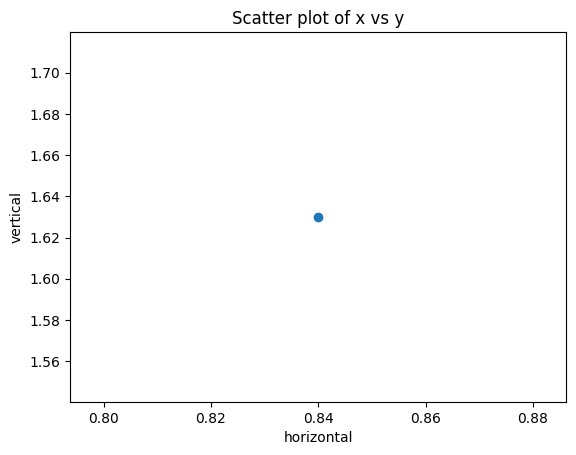

In [17]:
import polars as pl
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df' and has columns 'x' and 'y'
plt.scatter(pitch_challenged_pereira["plate_x"], pitch_challenged_pereira["plate_z"])
plt.xlabel("horizontal")
plt.ylabel("vertical")
plt.title("Scatter plot of x vs y")
plt.show()

In [18]:
#https://github.com/instant-replay-academy/MLB-PitchFx-Python/blob/master/GamedaySample.ipynb

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

"""matplotlib.pyplot is a collection of command shell style functions that make matplotlib 
work like MATLAB. Each pyplot function makes some change to a figure: e.g., creates a figure, 
creates a plotting area in a figure, plots some lines in a plotting area, decorates the plot with labels, etc.
Pyplot maintains state across calls."""

fig1 = plt.figure()
ax1 = fig1.add_subplot(111, aspect='equal')

platewidthInFeet = 17 / 12 # plate is 17 inches wide
expandedPlateInFeet = 20 / 12 # add ball width (half on each side)
szHeightInFeet = 3.5 - 1.5
ballInFeet = 3 / 12
halfBallInFeet = ballInFeet / 2

# draw expanded zone: 3 inch ball (.25 ft) = 1.5 inches all the way around
# ax1.add_patch(patches.Rectangle((expandedPlateInFeet/-2, 1.5 - halfBallInFeet), expandedPlateInFeet, szHeightInFeet + ballInFeet, color='lightblue'))

# draw formal zone (plate only)
ax1.add_patch(patches.Rectangle((platewidthInFeet/-2, 1.5), platewidthInFeet, szHeightInFeet))

# dray my pitch
ax1.scatter(pitch_challenged_pereira["plate_x"], pitch_challenged_pereira["plate_z"], color='red')

plt.ylim(0, 5)
plt.xlim(-2, 2)


(-2.0, 2.0)

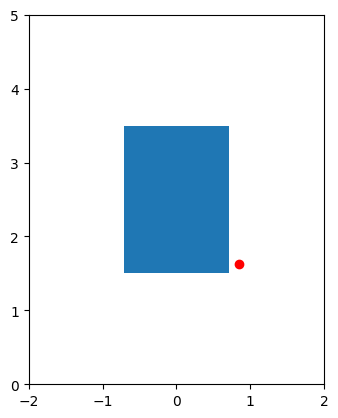

In [19]:
plt.show()

# Pull in Sheet with ABS data

In [21]:
# See above - we've created an API key in a file called 'apikey', 
# in the same directory as this notebook
filename = 'apikey'
def get_file_contents(filename):
    """ Given a filename,
        return the contents of that file
    """
    try:
        with open(filename, 'r') as f:
            # It's assumed our file contains a single line,
            # with our API key
            return f.read().strip()
    except FileNotFoundError:
        print("'%s' file not found" % filename)
api_key = get_file_contents(filename)
# print("Our API key is: %s" % (api_key))

In [93]:
# https://medium.com/@techworldthink/accessing-google-sheet-data-with-python-a-practical-guide-using-the-google-sheets-api-dc57759d387a

import requests

def get_google_sheet_data(spreadsheet_id,sheet_name, api_key):
    # Construct the URL for the Google Sheets API
    url = f'https://sheets.googleapis.com/v4/spreadsheets/{spreadsheet_id}/values/{sheet_name}!A1:Z?alt=json&key={api_key}'

    try:
        # Make a GET request to retrieve data from the Google Sheets API
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for HTTP errors

        # Parse the JSON response
        data = response.json()
        return data

    except requests.exceptions.RequestException as e:
        # Handle any errors that occur during the request
        print(f"An error occurred: {e}")
        return None


# configurations
spreadsheet_id = '11VW8sm80ezLvvxBL-tJeAtRQZsreRzDkr3KcSP17f8A'
sheet_name = "2025"

sheet_data = get_google_sheet_data(spreadsheet_id, sheet_name, api_key)

if sheet_data:
    pprint.pprint(sheet_data)
else:
    print("Failed to fetch data from Google Sheets API.")

{'majorDimension': 'ROWS',
 'range': "'2025'!A1:Z1000",
 'values': [['abs_index',
             'abs_successful',
             'abs_type',
             'abs_caller',
             'game_date',
             'batter_first_name',
             'batter_last_name',
             'pitcher_first_name',
             'pitcher_last_name',
             'home_team',
             'away_team',
             'inning',
             'outs_when_up',
             'balls',
             'strikes',
             'source',
             'Contributor'],
            ['0',
             'yes',
             'Strike To Ball',
             'batter',
             '2025-02-22',
             'Everson',
             'Pereira',
             'Eric',
             'Pardinho',
             'TOR',
             'NYY',
             '6',
             '2',
             '3',
             '2',
             'https://www.espn.com/mlb/story/_/id/43973088/new-york-yankees-use-abs-challenge-system-keep-inning-alive',
             'Seth Billia

In [89]:
# Grab data from the excel sheet and construct a polars dataframe. 
sheet_2025 = sheet_data["values"]
abs_challenges = pl.DataFrame(sheet_2025[1:len(sheet_2025)], 
                              schema = {key:str for key in sheet_2025[0]},
                              orient="row")
# By default, all columns come in as str types, so cast numerical columns as appropriate
abs_challenges = abs_challenges.with_columns(
    pl.col("abs_index").cast(pl.Int32),
    pl.col("inning").cast(pl.Int8),
    pl.col("balls").cast(pl.Int8),
    pl.col("strikes").cast(pl.Int8),
    pl.col("outs_when_up").cast(pl.Int8),
    pl.col("game_date").cast(pl.Date)
)

In [90]:
abs_challenges

abs_index,abs_successful,abs_type,abs_caller,game_date,batter_first_name,batter_last_name,pitcher_first_name,pitcher_last_name,home_team,away_team,inning,outs_when_up,balls,strikes,source,Contributor
i32,str,str,str,date,str,str,str,str,str,str,i8,i8,i8,i8,str,str
0,"""yes""","""Strike To Ball""","""batter""",2025-02-22,"""Everson""","""Pereira""","""Eric""","""Pardinho""","""TOR""","""NYY""",6,2,3,2,"""https://www.espn.com/mlb/story…","""Seth Billiau"""
1,"""yes""","""Ball To Strike""","""catcher""",2025-02-21,"""Kyle""","""Farmer""","""Corbin""","""Burnes""","""AZ""","""COL""",1,1,1,2,"""https://www.sportico.com/leagu…","""Seth Billiau"""
2,"""yes""","""Ball To Strike""","""catcher""",2025-02-20,"""Max""","""Muncy""","""Cody""","""Poteet""","""LAD""","""CHC""",1,0,0,1,"""https://www.mlb.com/video/cubs…","""Seth Billiau"""
3,"""yes""","""Strike To Ball""","""batter""",2025-02-23,"""Andy""","""Pages""","""Manuel""","""Castro""","""LAD""","""SD""",3,2,0,2,"""https://x.com/TalkingFriars/st…","""Seth Billiau"""
4,"""yes""","""Ball To Strike""","""catcher""",2025-02-25,"""Cole""","""Fontenelle""","""Yuki""","""Matsui""","""SD""","""LAA""",5,0,1,1,"""https://x.com/TalkingFriars/st…","""Seth Billiau"""
5,"""yes""","""Ball To Strike""","""catcher""",2025-02-25,"""Rio""","""Foster""","""Jacob""","""Higginbotham""","""SD""","""LAA""",8,0,3,2,"""https://x.com/TalkingFriars""","""Seth Billiau"""
6,"""no""","""Ball To Strike""","""catcher""",2025-02-25,"""Carter""","""Kieboom""","""Omar""","""Cruz""","""SD""","""LAA""",7,0,2,2,"""https://x.com/TalkingFriars/st…","""Seth Billiau"""
7,"""no""","""Ball To Strike""","""catcher""",2025-02-23,"""Jazz""","""Chisholm""","""Eric""","""Orze""","""TB""","""NYY""",3,2,3,2,"""https://x.com/JomboyMedia/stat…","""Seth Billiau"""
